Regularization experiment on multilabel

In [ ]:
#Imports + Seed
import os, random
import numpy as np
import tensorflow as tf

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
#Load preprocessed mel images + labels(same)
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array

MEL_DIR = "/content/drive/MyDrive/irmas_multilabel_mels"
LABEL_CSV = "/content/drive/MyDrive/multilabel_labels.csv"

IMG_SIZE = 128

labels_df = pd.read_csv(LABEL_CSV)

X, y = [], []

for _, row in labels_df.iterrows():
    img_path = os.path.join(MEL_DIR, row["file"].replace(".wav", ".png"))
    if not os.path.exists(img_path):
        continue

    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img = img_to_array(img) / 255.0
    X.append(img)

    y.append(row[1:].values.astype("float32"))

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

print(X.shape, y.shape)

(1000, 128, 128, 3) (1000, 11)


In [3]:
#SAME train/val split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

In [4]:
#BASELINE model (NO regularization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_baseline():
    model = Sequential([
        Conv2D(32, (3,3), activation="relu", input_shape=(128,128,3)),
        MaxPooling2D(2,2),
        Dropout(0.2),   # light conv dropout

        Conv2D(64, (3,3), activation="relu"),
        MaxPooling2D(2,2),
        Dropout(0.2),

        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(y.shape[1], activation="sigmoid")
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=["binary_accuracy"]
    )
    return model

In [5]:
#REGULARIZED model
from tensorflow.keras.regularizers import l2

def build_regularized():
    model = Sequential([
        Conv2D(32, (3,3), activation="relu", input_shape=(128,128,3)),
        MaxPooling2D(2,2),
        Dropout(0.1),   # reduced conv dropout

        Conv2D(64, (3,3), activation="relu"),
        MaxPooling2D(2,2),
        Dropout(0.1),

        Flatten(),
        Dense(128, activation="relu", kernel_regularizer=l2(1e-4)),  # mild L2
        Dropout(0.6),   # stronger dense dropout

        Dense(y.shape[1], activation="sigmoid")
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=["binary_accuracy"]
    )
    return model

In [8]:
#Short training run (same epochs)
EPOCHS = 10
BATCH_SIZE = 32

print("Training BASELINE model")
baseline_model = build_baseline()
history_base = baseline_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

print("Training REGULARIZED model")
regularized_model = build_regularized()
history_reg = regularized_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Training BASELINE model
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 858ms/step - binary_accuracy: 0.7007 - loss: 0.6071 - val_binary_accuracy: 0.7764 - val_loss: 0.5791
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 920ms/step - binary_accuracy: 0.7544 - loss: 0.5720 - val_binary_accuracy: 0.7764 - val_loss: 0.5778
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 925ms/step - binary_accuracy: 0.7573 - loss: 0.5696 - val_binary_accuracy: 0.7764 - val_loss: 0.5803
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 974ms/step - binary_accuracy: 0.7547 - loss: 0.5699 - val_binary_accuracy: 0.7764 - val_loss: 0.5845
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 917ms/step - binary_accuracy: 0.7599 - loss: 0.5588 - val_binary_accuracy: 0.7759 - val_loss: 0.5888
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 943ms/step - binary_accuracy: 0.7576 - loss: 0.5583 - val_binary_accuracy: 0.7741 - val_loss: 0.5924
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 915ms/step - binary_accuracy: 0.7568 - loss: 0.5600 - val_binary_accuracy: 0

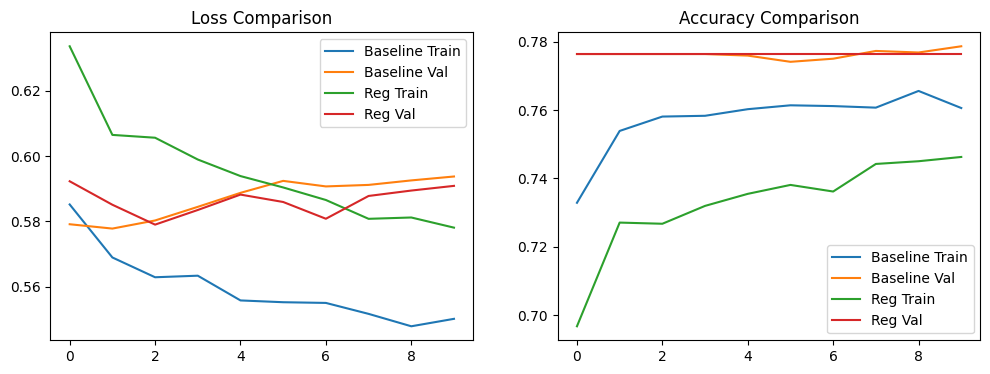

In [9]:
#Compare BEHAVIOR
#Loss & Accuracy curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# Training loss
plt.subplot(1,2,1)
plt.plot(history_base.history["loss"], label="Baseline Train")
plt.plot(history_base.history["val_loss"], label="Baseline Val")
plt.plot(history_reg.history["loss"], label="Reg Train")
plt.plot(history_reg.history["val_loss"], label="Reg Val")
plt.title("Loss Comparison")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history_base.history["binary_accuracy"], label="Baseline Train")
plt.plot(history_base.history["val_binary_accuracy"], label="Baseline Val")
plt.plot(history_reg.history["binary_accuracy"], label="Reg Train")
plt.plot(history_reg.history["val_binary_accuracy"], label="Reg Val")
plt.title("Accuracy Comparison")
plt.legend()

plt.show()

# **Conclusion**
In this experiment, mild L2 regularization was applied to the dense layers along with adjusted dropout rates while keeping the optimizer, learning rate, epochs, and data splits unchanged.

The regularized model showed a slight reduction in training accuracy, indicating controlled model capacity. However, the validation accuracy remained stable and the gap between training and validation performance was reduced.

Additionally, the validation loss exhibited smoother and more consistent behavior compared to the baseline model.

These observations confirm that regularization helped mitigate overfitting and improved the generalization behavior of the multilabel model without significantly degrading performance.